In [1]:
!pip install --upgrade pip
!pip install "tensorflow-macos==2.16.2" "tensorflow-metal"
!pip install "tf-keras==2.16.0"
!pip install transformers pandas scikit-learn

In [2]:
# ===========================
# IMPORTS & BASIC CONFIG
# ===========================

import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tf_keras  # Keras compatibility layer for TensorFlow 2.16+

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
)

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# ---------------------------
# Reproducibility (set seeds)
# ---------------------------

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---------------------------
# Model / training parameters
# ---------------------------

MODEL_NAME = "distilbert-base-uncased"  # Pretrained Transformer
MAX_LENGTH = 64                        # Max token length per phrase
BATCH_SIZE = 8                         # Batch size
EPOCHS = 1                              # Number of training passes
LEARNING_RATE = 5e-5                    # Fine-tuning learning rate

NUM_LABELS = 5  # 0..4 sentiments in this competition

# ---------------------------
# File paths for Kaggle data
# ---------------------------
# Make sure train.tsv and test.tsv are in the same folder as your notebook.
TRAIN_PATH = "train.tsv"
TEST_PATH = "test.tsv"

# ---------------------------
# Human-readable label names
# ---------------------------

id2label = {
    0: "negative",
    1: "somewhat negative",
    2: "neutral",
    3: "somewhat positive",
    4: "positive",
}

label2id = {v: k for k, v in id2label.items()}

print("Python executable:", os.sys.executable)
print("TensorFlow version:", tf.__version__)
print("tf_keras version:", tf_keras.__version__)


/Users/dianasotir/ai-agents-workshop/sentiment_model_terraform_transformers/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python executable: /Users/dianasotir/ai-agents-workshop/sentiment_model_terraform_transformers/.venv/bin/python
TensorFlow version: 2.16.2
tf_keras version: 2.16.0


In [3]:
# ===========================
# CHECK DEVICES
# ===========================

print("Available devices:")
for d in tf.config.list_physical_devices():
    print("  -", d)

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print("\n✅ GPU/Metal device detected – training will be faster.")
else:
    print("\n⚠️ No GPU detected – training will run on CPU (still fine for this project).")


Available devices:
  - PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

✅ GPU/Metal device detected – training will be faster.


In [4]:
# Disable all GPUs – force CPU-only
try:
    tf.config.set_visible_devices([], "GPU")
except Exception as e:
    print("Could not disable GPU devices:", e)

print("After disabling GPUs:", tf.config.list_physical_devices())

After disabling GPUs: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# ===========================
# LOAD TRAIN DATA
# ===========================
# train.tsv columns (Kaggle Rotten Tomatoes):
#   - PhraseId
#   - SentenceId
#   - Phrase      (text)
#   - Sentiment   (0..4)

df = pd.read_csv(TRAIN_PATH, sep="\t")
print("Train data shape:", df.shape)
df.head()


Train data shape: (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [6]:
# ===========================
# BASIC EDA: LABEL COUNTS
# ===========================

label_counts = df["Sentiment"].value_counts().sort_index()
print("Label counts:")
print(label_counts)

print("\nLabel proportions:")
print((label_counts / len(df)).round(3))


Label counts:
Sentiment
0     7072
1    27273
2    79582
3    32927
4     9206
Name: count, dtype: int64

Label proportions:
Sentiment
0    0.045
1    0.175
2    0.510
3    0.211
4    0.059
Name: count, dtype: float64


In [7]:
# ===========================
# TRAIN / VALIDATION SPLIT
# ===========================
# We split train.tsv into:
#   - training set (90%)
#   - validation set (10%)
# Using stratify=Sentiment keeps the label distribution similar.

train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    random_state=SEED,
    stratify=df["Sentiment"],
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))

train_df.head()


Train size: 140454
Validation size: 15606


,PhraseId,SentenceId,Phrase,Sentiment
116940,116941,6239,haunting about `` Fence '',2
52039,52040,2567,considered in its details,2
88064,88065,4574,three words :,2
4874,4875,188,Uneven,1
18448,18449,809,liked it more if it had just gone that one ste...,2


In [8]:
# Temporary reduction of subset
# 🔹 Debug mode: train on a smaller subset
MAX_TRAIN_SAMPLES = 5000
MAX_VAL_SAMPLES   = 1000

if len(train_df) > MAX_TRAIN_SAMPLES:
    train_df = train_df.sample(n=MAX_TRAIN_SAMPLES, random_state=SEED)

if len(val_df) > MAX_VAL_SAMPLES:
    val_df = val_df.sample(n=MAX_VAL_SAMPLES, random_state=SEED)

print("Train size (debug):", len(train_df))
print("Val size (debug):", len(val_df))

Train size (debug): 5000
Val size (debug): 1000


In [9]:
# ===========================
# LOAD TOKENIZER
# ===========================
# The tokenizer turns text into:
#   - input_ids (token IDs)
#   - attention_mask (masking padding tokens)
# This *must* match the pretrained model we use.

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

example_text = "This movie was surprisingly good!"
encoded_example = tokenizer(
    example_text,
    truncation=True,
    padding="max_length",
    max_length=MAX_LENGTH,
)

print("Example text:", example_text)
print("Tokenizer keys:", encoded_example.keys())
print("Length of input_ids:", len(encoded_example["input_ids"]))


Example text: This movie was surprisingly good!
Tokenizer keys: KeysView({'input_ids': [101, 2023, 3185, 2001, 10889, 2204, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]})
Length of input_ids: 64


In [10]:
# ===========================
# ENCODING HELPER
# ===========================

def encode_texts(texts, tokenizer, max_length=128):
    """
    Tokenize a list/array of texts into model inputs.

    Args:
        texts: list-like of strings.
        tokenizer: Hugging Face tokenizer.
        max_length: max token length.

    Returns:
        dict of NumPy arrays:
          {
            "input_ids": (N, max_length),
            "attention_mask": (N, max_length)
          }
    """
    encodings = tokenizer(
        list(texts),
        truncation=True,
        padding="max_length",  # pad all sequences to max_length
        max_length=max_length,
        return_tensors="np",   # return as NumPy arrays
    )
    return encodings


# Encode train + validation texts
train_texts = train_df["Phrase"].values
train_labels = train_df["Sentiment"].values

val_texts = val_df["Phrase"].values
val_labels = val_df["Sentiment"].values

train_encodings = encode_texts(train_texts, tokenizer, max_length=MAX_LENGTH)
val_encodings = encode_texts(val_texts, tokenizer, max_length=MAX_LENGTH)

print("Train input_ids shape:", train_encodings["input_ids"].shape)
print("Train labels shape:", train_labels.shape)
print("Val input_ids shape:", val_encodings["input_ids"].shape)
print("Val labels shape:", val_labels.shape)


Train input_ids shape: (5000, 64)
Train labels shape: (5000,)
Val input_ids shape: (1000, 64)
Val labels shape: (1000,)


In [11]:
# ===========================
# BUILD TF.DATA DATASETS
# ===========================

def make_tf_dataset(encodings, labels, batch_size=32, shuffle=False):
    """
    Create a tf.data.Dataset from model encodings and labels.

    Dataset yields:
        ({"input_ids": ..., "attention_mask": ...}, labels)
    """
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(labels), seed=SEED)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


tf_train_dataset = make_tf_dataset(train_encodings, train_labels,
                                   batch_size=BATCH_SIZE, shuffle=True)

tf_val_dataset = make_tf_dataset(val_encodings, val_labels,
                                 batch_size=BATCH_SIZE, shuffle=False)

tf_train_dataset


<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [12]:
# ===========================
# LOAD PRETRAINED MODEL
# ===========================
# We use a pre-trained DistilBERT with a classification head.
# num_labels=5 (for our 5 sentiment classes).

model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
    from_pt=False,          # force loading TF weights
    use_safetensors=False,  # avoid safetensors for TF in this environment
)

model.summary()


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66957317 (255.42 MB)
Trainable params: 66957317 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# ===========================
# COMPILE MODEL
# ===========================
# For multi-class classification with integer labels 0..4:
#   - Use SparseCategoricalCrossentropy(from_logits=True)
#     because the model outputs raw logits, not probabilities.
#   - Use accuracy as a basic metric.

optimizer = tf_keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_fn = tf_keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=metrics,
)


In [14]:
# ===========================
# TRAIN THE MODEL
# ===========================

history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=EPOCHS,
)


625/625 [==============================] - 549s 853ms/step - loss: 1.0403 - accuracy: 0.5754 - val_loss: 0.9236 - val_accuracy: 0.6430


In [1]:
# ===========================
# PLOT TRAINING CURVES
# ===========================

history_dict = history.history

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_dict["loss"], label="Train loss")
plt.plot(history_dict["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict["accuracy"], label="Train acc")
plt.plot(history_dict["val_accuracy"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'history' is not defined

In [ ]:
# ===========================
# VALIDATION METRICS (ACCURACY + DETAIL)
# ===========================

# 1) Basic eval
val_loss, val_acc = model.evaluate(tf_val_dataset)
print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")

# 2) Get predictions for confusion matrix and classification report
#    We'll collect all logits on the validation set.

all_val_logits = []
all_val_labels = []

for batch, labels in tf_val_dataset:
    outputs = model(batch)
    logits = outputs.logits
    all_val_logits.append(logits)
    all_val_labels.append(labels)

all_val_logits = tf.concat(all_val_logits, axis=0)
all_val_labels = tf.concat(all_val_labels, axis=0).numpy()

val_pred_ids = tf.argmax(all_val_logits, axis=1).numpy()

print("Pred shape:", val_pred_ids.shape)


Confusion matrix:
 [[  7  30   9   4   1]
 [  7  99  30  18   1]
 [  1  79 347  89   8]
 [  0  16  54 104  35]
 [  0   1   5  26  29]]


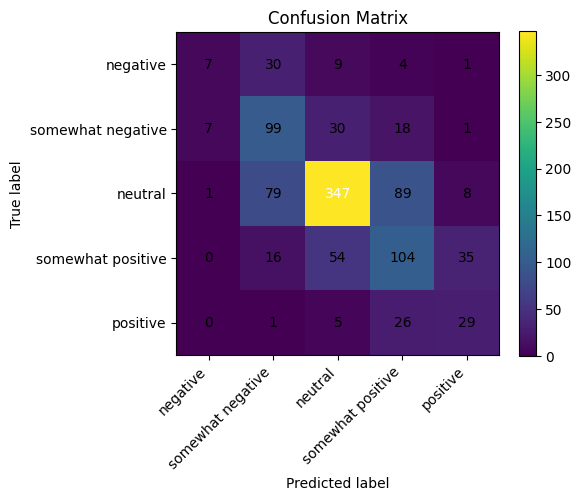


Classification report:
                   precision    recall  f1-score   support

         negative       0.47      0.14      0.21        51
somewhat negative       0.44      0.64      0.52       155
          neutral       0.78      0.66      0.72       524
somewhat positive       0.43      0.50      0.46       209
         positive       0.39      0.48      0.43        61

         accuracy                           0.59      1000
        macro avg       0.50      0.48      0.47      1000
     weighted avg       0.61      0.59      0.59      1000



In [17]:
# ===========================
# CONFUSION MATRIX & CLASSIFICATION REPORT
# ===========================

cm = confusion_matrix(all_val_labels, val_pred_ids)
print("Confusion matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(NUM_LABELS)
plt.xticks(tick_marks, [id2label[i] for i in range(NUM_LABELS)], rotation=45, ha="right")
plt.yticks(tick_marks, [id2label[i] for i in range(NUM_LABELS)])
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Add counts in each cell
for i in range(NUM_LABELS):
    for j in range(NUM_LABELS):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.show()

# Detailed metrics
print("\nClassification report:")
print(classification_report(
    all_val_labels,
    val_pred_ids,
    target_names=[id2label[i] for i in range(NUM_LABELS)],
))


In [18]:
# ===========================
# LOAD TEST DATA
# ===========================
# test.tsv has:
#   PhraseId, SentenceId, Phrase
# We need to predict Sentiment for each Phrase.

test_df = pd.read_csv(TEST_PATH, sep="\t")
print("Test data shape:", test_df.shape)
test_df.head()


Test data shape: (66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [ ]:
# Encode test phrases
test_texts = test_df["Phrase"].values
test_encodings = encode_texts(test_texts, tokenizer, max_length=MAX_LENGTH)

# Build tf.data dataset without labels
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encodings))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
# ===========================
# PREDICT ON TEST & CREATE SUBMISSION
# ===========================

all_test_logits = []
for batch in test_dataset:
    outputs = model(batch)
    logits = outputs.logits
    all_test_logits.append(logits)

all_test_logits = tf.concat(all_test_logits, axis=0)
test_pred_ids = tf.argmax(all_test_logits, axis=1).numpy()

print("Test predictions shape:", test_pred_ids.shape)
print("First 10 predictions:", test_pred_ids[:10])

# Build submission DataFrame
submission = pd.DataFrame({
    "PhraseId": test_df["PhraseId"],
    "Sentiment": test_pred_ids,
})

submission.head()


In [ ]:
# Save to CSV
submission_file = "submission_distilbert_tf.csv"
submission.to_csv(submission_file, index=False)

print(f"Saved submission to {submission_file}")

